In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')

## Exploratory Analysis

In [4]:
df.shape[0]

294478

In [5]:
df['user_id'].nunique()

290584

In [6]:
# proportion of users converted
df['converted'].mean()

0.11965919355605512

In [7]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
# checking to see if treatment group received the correct landing page
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [9]:
df.isnull().values.sum()

0

In [10]:
# dropping rows with incorrect landing pages 
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page") or (group == "control" and landing_page != "old_page") or (group != "control" and landing_page == "old_page")').index)


In [11]:
# confirming correct rows have been dropped
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
df2['user_id'].nunique()

290584

In [13]:
# checking for duplicate users
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop(df2[(df2.user_id == 773192) & (df2['timestamp'] == '2017-01-09 05:37:58.781806')].index)

In [16]:
df2['user_id'].duplicated().sum()

0

In [17]:
#proportion of total users converted
df['converted'].mean()

0.11965919355605512

In [18]:
#proportion of control group converted
df.query('group == "control"')['converted'].mean()

0.12039917935897611

In [19]:
#proportion of treatment group converted
df.query('group == "treatment"')['converted'].mean()

0.11891957956489856

In [20]:
df2[df2.landing_page == 'new_page'].user_id.count()/df2.shape[0]

0.5000619442226688

### Assuming old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

$$ H_0: P_{new}  - P_{old} \leq 0  \\ 
 H_1: P_{new}  - P_{old} > 0 $$


In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

In [22]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [23]:
n_new = df2[df2.landing_page == 'new_page'].user_id.count()
n_new

145310

In [24]:
n_old = df2[df2.landing_page == 'old_page'].user_id.count()
n_old

145274

In [25]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1-p_new), p_new])

In [26]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1-p_old), p_old])

In [27]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.000848651515112514

In [28]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

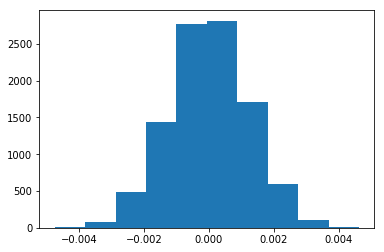

In [29]:
#plotting histogram 
plt.hist(p_diffs);

In [30]:
p_diffs = np.array(p_diffs)
np.std(p_diffs)

0.0012153612859693381

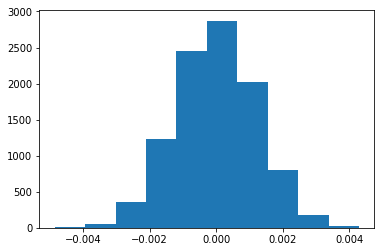

In [31]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals);

In [73]:
(null_vals > obs_diff).mean()

0.73709999999999998

**The test carried out above provides a p-value of 73.7% which will means that we fail to reject the null hypothesis. This suggests that the null hypothesis is true there is likely no difference between the old and new pages or the old page is significantly better than the new page**

### Using built in functions to see if I get similar results

In [32]:
import statsmodels.api as sm

In [33]:
convert_old = df2[df2['landing_page'] == 'old_page']['converted'].sum()
convert_old

17489

In [34]:
convert_new = df2[df2['landing_page'] == 'new_page']['converted'].sum()
convert_new

17264

In [35]:
n_old = df2[df2['landing_page'] == 'old_page']['converted'].size
n_new = df2[df2['landing_page'] == 'new_page']['converted'].size
n_old, n_new

(145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
z_score, p_value

(-1.3109241984234394, 0.18988337448195103)

In [37]:
from scipy.stats import norm

norm.cdf(z_score)

norm.ppf(1-(0.05/2))

1.959963984540054

**The z-score computed does not exceed the critical value of 1.95 and the p-value exceeds the error rate of 5% which tells us we should fail to reject the null hypothesis. This gives us the same conclusion as the findings above**

### Using a regression approach

In [38]:
df2['intercept'] = 1
df2[['drop', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop(['drop'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [39]:
lgt = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lgt.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        17:03:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [40]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

**The logistic regression model results above show that the ab page variable is not statistically significant due to the p-value being 0.19 higher than the percentage error of 5%**

**It is different from the p-value found in part 2 because the logistic regression tests different null and alternative hypotheses than a standard hypothesis test. It tests if the response variable is one of two outcomes**

**It is a good idea to consider other factors to add into the regression model because our response variable may be affected my multiple factors and we will have a clearer picture into how it responds. However there could be possible disadvantages to adding predictor variables because they may be correlated with one another when we want them to be correlated with only our response variable. This is referred to as multicollinearity**

In [41]:
df3 = pd.read_csv('countries.csv')
df_new = df3.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [42]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [43]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [44]:
lgt2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
results2 = lgt2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 23 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        17:03:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [45]:
np.exp(results2.params)

intercept    0.131332
ab_page      0.985168
US           1.041599
UK           1.051944
dtype: float64

**From the observations above we conclude that people living in the US are 5% more likely to convert than people from Canada which we have used as our baseline. We also see that people from the UK are 4% more likely to convert. This will provide little to no significance in our test and the p-values are higher than our alpha value of 0.05 to furhter support this**

In [46]:
df_new['new_CA'] = df_new['ab_page']*df_new['CA']
df_new['new_UK'] = df_new['ab_page']*df_new['UK']
df_new['new_US'] = df_new['ab_page']*df_new['US']

In [47]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,new_CA,new_UK,new_US
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [48]:
lgt3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'new_US', 'UK', 'new_UK']])
results3 = lgt3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 23 Jan 2019   Pseudo R-squ.:               3.482e-05
Time:                        17:03:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
new_US         0.0469      0.054      0.872      0.383      -0.059       0.152
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
new_UK         0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

**Based on the results above none of the p-values suggest the results are statistically significant enough to predict the converted rates, the interaction between page and country observed also shows no significant change and will not be helpful to predict the converted rates**